In [125]:
%matplotlib inline
import momi		## momi2 analysis
import logging		## create log file

logging.basicConfig(level=logging.INFO,
                    filename="momi_agl_log.txt")

In [126]:
sfs = momi.Sfs.load("agl-hom_comb_SNPs_phased-filtered-50per.sfs.gz")
print("Avg pairwise heterozygosity", sfs.avg_pairwise_hets[:5])
print("populations", sfs.populations)
print("percent missing data per population", sfs.p_missing)

Avg pairwise heterozygosity [[0.87995169 0.57142857 0.33333333]
 [0.72183794 0.57142857 0.        ]
 [0.51897861 0.25       0.        ]
 [0.25362319 0.53571429 0.18518519]
 [0.9770751  0.         0.        ]]
populations ('P_ag', 'P_agA', 'P_ho')
percent missing data per population [0.19339623 0.1509434  0.23396226]


In [127]:
#test. pure isolation model, not estimating any parameters. Not used in paper.
no_migration_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

no_migration_model.set_data(sfs)

no_migration_model.add_leaf("P_ag")
no_migration_model.add_leaf("P_ho")
no_migration_model.move_lineages("P_ho", "P_ag", t=1.4e6)

no_migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:458: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)] + [0] * len(b.pop_labels)]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

            fun: 4.445527123096277
            jac: array([], dtype=float64)
  kl_divergence: 4.445527123096277
 log_likelihood: -280.16092124825843
        message: 'All lower bounds are equal to the upper bounds'
           nfev: 0
            nit: 0
     parameters: ParamsDict({})
         status: 5
        success: False
              x: array([], dtype=float64)

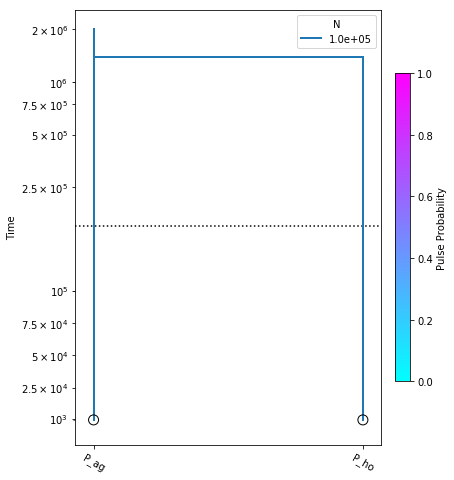

In [148]:
yticks = [1e3, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    no_migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [129]:
#pure isolation model estimate pop sizes for P. ag and P. hom
popsizes_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

popsizes_model.set_data(sfs)

popsizes_model.add_size_param("n_ag")
popsizes_model.add_size_param("n_ho")

popsizes_model.add_leaf("P_ag", N="n_ag")
popsizes_model.add_leaf("P_ho", N="n_ho")
popsizes_model.move_lineages("P_ho", "P_ag", t=1.4e6)

popsizes_model.stochastic_optimize(num_iters=2000,n_minibatches=10)
popsizes_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5948818192242777
            jac: array([-4.47029107e-07,  7.71835912e-08])
  kl_divergence: 2.5948818192242777
 log_likelihood: -187.62865605465845
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 11
            nit: 5
     parameters: ParamsDict({'n_ag': 1109711.490643479, 'n_ho': 605273.1858197119})
         status: 1
        success: True
              x: array([13.91961062, 13.31343518])

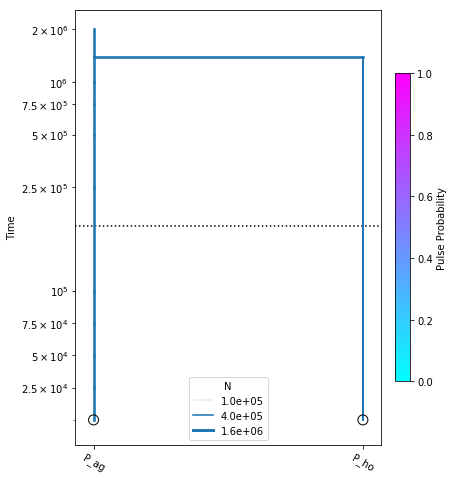

In [130]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    popsizes_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [131]:
#assymetric migration model with single pulse from aglaiae to homochrous
#because this is coalescent, pulses are modeled "backwards"
#i.e. move_lineages from ho to ag in coalescent time is equivalent to migration from ag to ho in forward time

migration_model = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model.set_data(sfs)

migration_model.add_time_param("tmig_ho_ag")
migration_model.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model.add_size_param("n_ag")
migration_model.add_size_param("n_ho")

migration_model.add_leaf("P_ag", N="n_ag")
migration_model.add_leaf("P_ho", N="n_ho")
migration_model.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.502111950761942
            jac: array([ 3.95001381e-07,  5.77093595e-03,  7.14167466e-03, -1.95192398e-03])
  kl_divergence: 2.502111950761942
 log_likelihood: -182.99016263154164
        message: 'Max. number of function evaluations reached'
           nfev: 100
            nit: 21
     parameters: ParamsDict({'tmig_ho_ag': 8474.26988479527, 'mfrac_ho_ag': 0.8856525327456847, 'n_ag': 79693.17029120708, 'n_ho': 3628.859539166066})
         status: 3
        success: False
              x: array([8.47426988e+03, 2.04708293e+00, 1.12859392e+01, 8.19667370e+00])

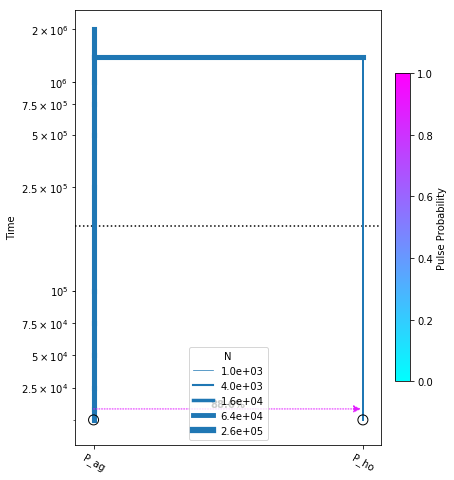

In [132]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [133]:
#assymetrical migration model 2 where pulse from hom to agl

migration_model2 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model2.set_data(sfs)

migration_model2.add_time_param("tmig_ag_ho")
#migration_model2.add_time_param("tmig_ho_ag")
migration_model2.add_pulse_param("mfrac_ag_ho", upper=1.0)
#migration_model2.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model2.add_size_param("n_ag")
migration_model2.add_size_param("n_ho")

migration_model2.add_leaf("P_ag", N="n_ag")
migration_model2.add_leaf("P_ho", N="n_ho")
migration_model2.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
#migration_model2.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model2.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model2.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model2.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5509592586203818
            jac: array([-1.28683836e-07, -9.77568901e-04,  7.36150579e-04, -3.41561546e-04])
  kl_divergence: 2.5509592586203818
 log_likelihood: -185.43252802446364
        message: 'Max. number of function evaluations reached'
           nfev: 100
            nit: 20
     parameters: ParamsDict({'tmig_ag_ho': 7431.359078312293, 'mfrac_ag_ho': 0.9767729001236279, 'n_ag': 3632.9442147486056, 'n_ho': 13237.807944266193})
         status: 3
        success: False
              x: array([7.43135908e+03, 3.73893448e+00, 8.19779868e+00, 9.49083225e+00])

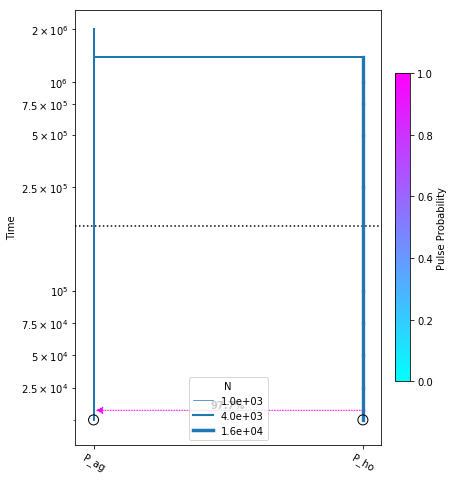

In [134]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model2, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [136]:
#ancestral migration older than 22000 years
migration_model3 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model3.set_data(sfs)

migration_model3.add_time_param("tmig_ag_ho", upper=1e6, lower=22000)
migration_model3.add_time_param("tmig_ho_ag",upper=1e6, lower=22000)
migration_model3.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model3.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model3.add_size_param("n_ag")
migration_model3.add_size_param("n_ho")

migration_model3.add_leaf("P_ag", N="n_ag")
migration_model3.add_leaf("P_ho", N="n_ho")
migration_model3.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model3.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model3.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model3.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model3.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.4293210337712563
            jac: array([ 0.00348546, -0.00215096, -0.00542247, -0.00126513, -0.02109926,
        0.00756394])
  kl_divergence: 2.4293210337712563
 log_likelihood: -179.35061678200736
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 75
            nit: 3
     parameters: ParamsDict({'tmig_ag_ho': 22955.82230698763, 'tmig_ho_ag': 22955.8223069853, 'mfrac_ag_ho': 0.8604969123971552, 'mfrac_ho_ag': 0.9495461822101088, 'n_ag': 17377.37698607309, 'n_ho': 12186.692312736715})
         status: 1
        success: True
              x: array([-6.92971512, -6.92971512,  1.81942329,  2.93492575,  9.76292447,
        9.40809984])

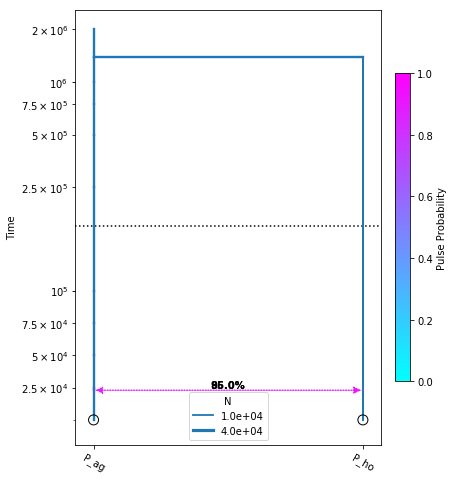

In [137]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model3, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [138]:
#secondary contact model younger than 22000 yrs
migration_model4 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model4.set_data(sfs)

migration_model4.add_time_param("tmig_ag_ho", upper=22000, lower=100)
migration_model4.add_time_param("tmig_ho_ag",upper=22000, lower=100)
migration_model4.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model4.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model4.add_size_param("n_ag")
migration_model4.add_size_param("n_ho")

migration_model4.add_leaf("P_ag", N="n_ag")
migration_model4.add_leaf("P_ho", N="n_ho")
migration_model4.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model4.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model4.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model4.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model4.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.4274540033737915
            jac: array([ 0.00032254, -0.00026614,  0.00266518, -0.00196005,  0.00839586,
        0.0013136 ])
  kl_divergence: 2.4274540033737915
 log_likelihood: -179.25726526213413
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 79
            nit: 4
     parameters: ParamsDict({'tmig_ag_ho': 21900.30629197649, 'tmig_ho_ag': 21900.306291969235, 'mfrac_ag_ho': 0.8697247879720326, 'mfrac_ho_ag': 0.9561689019983086, 'n_ag': 18016.321076085365, 'n_ho': 11536.810857960452})
         status: 1
        success: True
              x: array([5.38757673, 5.38757673, 1.8985276 , 3.08259101, 9.79903335,
       9.35329815])

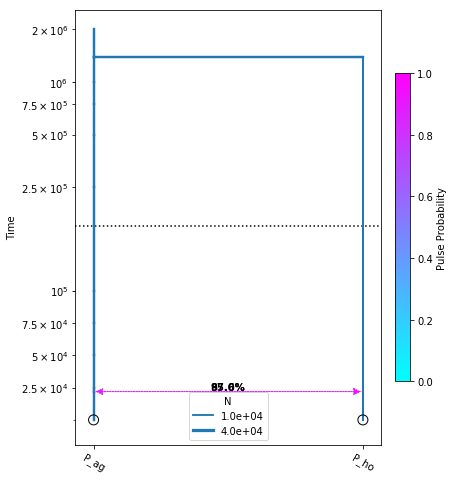

In [139]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model4, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [140]:
#continuous migration modeled as four evenly spaced bi-directional migration events at contemporary, 280, 560, 820, and 1120kya
migration_model5 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model5.set_data(sfs)

migration_model5.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho2", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag2", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho3", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag3", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho4", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag4", upper=1.0)

migration_model5.add_pulse_param("mfrac_ag_ho5", upper=1.0)
migration_model5.add_pulse_param("mfrac_ho_ag5", upper=1.0)

migration_model5.add_size_param("n_ag")
migration_model5.add_size_param("n_ho")

migration_model5.add_leaf("P_ag", N="n_ag")
migration_model5.add_leaf("P_ho", N="n_ho")

migration_model5.move_lineages("P_ag", "P_ho", t=10, p="mfrac_ag_ho")
migration_model5.move_lineages("P_ho", "P_ag", t=10, p="mfrac_ho_ag")

migration_model5.move_lineages("P_ag", "P_ho", t=280000, p="mfrac_ag_ho2")
migration_model5.move_lineages("P_ho", "P_ag", t=280000, p="mfrac_ho_ag2")

migration_model5.move_lineages("P_ag", "P_ho", t=560000, p="mfrac_ag_ho3")
migration_model5.move_lineages("P_ho", "P_ag", t=560000, p="mfrac_ho_ag3")

migration_model5.move_lineages("P_ag", "P_ho", t=840000, p="mfrac_ag_ho4")
migration_model5.move_lineages("P_ho", "P_ag", t=840000, p="mfrac_ho_ag4")

migration_model5.move_lineages("P_ag", "P_ho", t=1120000, p="mfrac_ag_ho5")
migration_model5.move_lineages("P_ho", "P_ag", t=1120000, p="mfrac_ho_ag5")

migration_model5.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model5.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model5.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.5045144827520405
            jac: array([-3.12461511e-06,  1.98912329e-09, -1.27693542e-05, -3.92435068e-06,
        2.79251062e-08,  1.24526291e-08,  1.32941841e-07,  2.60648860e-08,
        2.13682893e-07,  2.12411835e-07, -5.37374506e-07, -7.98802895e-07])
  kl_divergence: 2.5045144827520405
 log_likelihood: -183.11028923104658
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 59
            nit: 11
     parameters: ParamsDict({'mfrac_ag_ho': 0.005057812589825674, 'mfrac_ho_ag': 8.157988537427066e-09, 'mfrac_ag_ho2': 0.6146053455385917, 'mfrac_ho_ag2': 0.6030067202324627, 'mfrac_ag_ho3': 2.5142923215162333e-06, 'mfrac_ho_ag3': 8.328347427117216e-07, 'mfrac_ag_ho4': 9.648303994299266e-06, 'mfrac_ho_ag4': 1.7745405591260207e-06, 'mfrac_ag_ho5': 2.285432478600046e-05, 'mfrac_ho_ag5': 2.5878057347051663e-05, 'n_ag': 180928.8664652528, 'n_ho': 127476.43957097939})
         status: 1
        success: True
              x: array([ -5.28175054, -18.624268

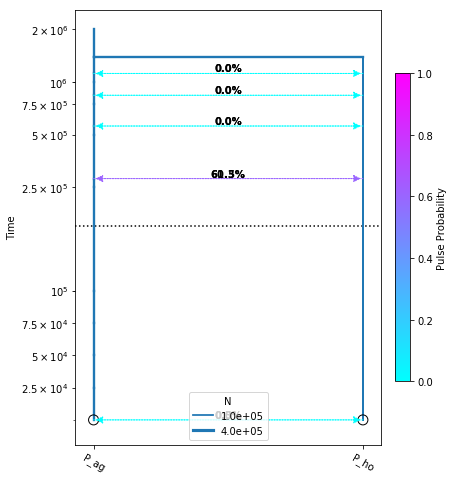

In [141]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model5, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [142]:
#repeated secondary contact model. biderctional pulse after LGM and pulse before LGM 22000 yrs ago

migration_model6 = momi.DemographicModel(N_e=1e5, muts_per_gen = None)

migration_model6.set_data(sfs)

migration_model6.add_time_param("tmig_ag_ho", upper=1e6, lower=22000)
migration_model6.add_time_param("tmig_ho_ag",upper=1e6, lower=22000)
migration_model6.add_pulse_param("mfrac_ag_ho", upper=1.0)
migration_model6.add_pulse_param("mfrac_ho_ag", upper=1.0)

migration_model6.add_time_param("tmig_ag_ho2", upper=22000, lower=100)
migration_model6.add_time_param("tmig_ho_ag2",upper=22000, lower=100)
migration_model6.add_pulse_param("mfrac_ag_ho2", upper=1.0)
migration_model6.add_pulse_param("mfrac_ho_ag2", upper=1.0)


migration_model6.add_size_param("n_ag")
migration_model6.add_size_param("n_ho")

migration_model6.add_leaf("P_ag", N="n_ag")
migration_model6.add_leaf("P_ho", N="n_ho")
migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho", p="mfrac_ag_ho")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag", p="mfrac_ho_ag")

migration_model6.move_lineages("P_ag", "P_ho", t="tmig_ag_ho2", p="mfrac_ag_ho2")
migration_model6.move_lineages("P_ho", "P_ag", t="tmig_ho_ag2", p="mfrac_ho_ag2")

migration_model6.move_lineages("P_ho", "P_ag", t=1.4e6)

migration_model6.stochastic_optimize(num_iters=2000, n_minibatches=10)
migration_model6.optimize()

/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  def __getitem__(A, idx): return A[idx]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:597: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depreca

            fun: 2.421969853505791
            jac: array([-2.03291637e-05,  1.79905156e-05,  2.06189341e-04,  2.32532540e-05,
       -8.26077699e-03,  9.46391113e-03,  2.24627120e-03, -2.92325340e-03,
       -1.14498930e-03,  4.46471616e-03])
  kl_divergence: 2.421969853505791
 log_likelihood: -178.9830577687341
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 86
            nit: 4
     parameters: ParamsDict({'tmig_ag_ho': 31691.473644411693, 'tmig_ho_ag': 40516.60948645517, 'mfrac_ag_ho': 0.0014306188731693663, 'mfrac_ho_ag': 0.002267718594711041, 'tmig_ag_ho2': 20451.087085956762, 'tmig_ho_ag2': 20451.087085958734, 'mfrac_ag_ho2': 0.9301640722196672, 'mfrac_ho_ag2': 0.8678627382323082, 'n_ag': 17382.617611613718, 'n_ho': 10560.274527212938})
         status: 1
        success: True
              x: array([-4.60430427, -3.94772687, -6.54821651, -6.08671068,  2.57558099,
        2.57558099,  2.58921239,  1.88219232,  9.763226  ,  9.26485455])

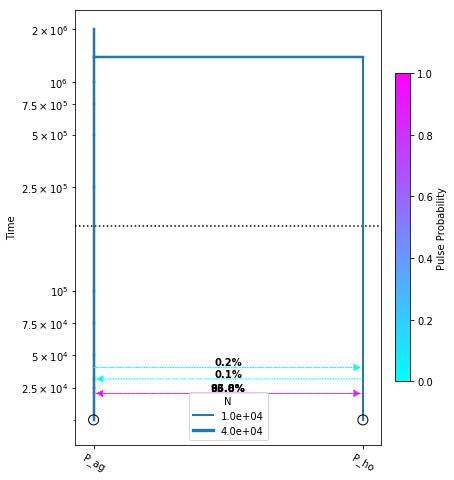

In [143]:
yticks = [2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5, 1e6, 2e6]

fig = momi.DemographyPlot(
    migration_model6, ["P_ag", "P_ho"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1.5e5)

In [144]:
import numpy as np

AICs = []
for model in [popsizes_model, migration_model, migration_model2, migration_model3, migration_model4, migration_model5, migration_model6]:
    lik = model.log_likelihood()
    nparams = len(model.get_params())
    aic = 2*nparams - 2*lik
    print("AIC {}".format(aic))
    AICs.append(aic)

minv = np.min(AICs)
delta_aic = np.array(AICs) - minv
print("Delta AIC per model: ", delta_aic)
print("AIC weight per model: ", np.exp(-0.5 * delta_aic))


/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:511: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)]],
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/momi/compute_sfs.py:458: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  [slice(None)] + [0] * len(b.pop_labels)]
/home/lmusher/array1/anaconda2/envs/momi-py36/lib/python3.6/site-packages/autograd/numpy/numpy_boxes.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; us

AIC 379.2573121093169
AIC 373.9803252630833
AIC 378.8650560489273
AIC 370.70123356401473
AIC 370.51453052426825
AIC 390.22057846209316
AIC 377.9661155374682
Delta AIC per model:  [ 8.74278159  3.46579474  8.35052552  0.18670304  0.         19.70604794
  7.45158501]
AIC weight per model:  [1.26336575e-02 1.76771495e-01 1.53711522e-02 9.10873254e-01
 1.00000000e+00 5.25879281e-05 2.40939982e-02]


In [ ]:
n_bootstraps = 250
# make copies of the original model to avoid changing them
migration_model4_copy = migration_model4.copy()

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}-th bootstrap out of {n_bootstraps}")

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    migration_model4_copy.set_data(resampled_sfs)
    #add_pulse_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    migration_model4_copy.set_params(randomize=True)
    migration_model4_copy.optimize()
    # initialize parameters from submodel, randomizing the new parameters
    #add_pulse_copy.set_params(pulse_copy.get_params(),
                              #randomize=True)
    #add_pulse_copy.optimize()

    bootstrap_results.append(migration_model4_copy.get_params())

In [ ]:
fig = momi.DemographyPlot(
    migration_model4, ["North", "South"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)

# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(
        params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/10)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="upper right")
